In [8]:
# First would be to install lightweight_mmm
# If you face the error that requests to restart runtime, Click the restart runtime button and re-install it.
!pip install --upgrade git+https://github.com/google/lightweight_mmm.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/google/lightweight_mmm.git to /tmp/pip-req-build-zod0_vuc
  Running command git clone --filter=blob:none --quiet https://github.com/google/lightweight_mmm.git /tmp/pip-req-build-zod0_vuc
  Resolved https://github.com/google/lightweight_mmm.git to commit 262a77d0e5c048b59a5e5a33c34873ae015bb9b5
  Preparing metadata (setup.py) ... done


In [3]:
!pip install numpyro

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.2/300.2 kB 12.4 MB/s eta 0:00:00


In [1]:
# Import jax.numpy and any other library we might need.
import jax.numpy as jnp
import numpyro

In [2]:
# Import the relevant modules of the library
from lightweight_mmm import lightweight_mmm
from lightweight_mmm import optimize_media
from lightweight_mmm import plot
from lightweight_mmm import preprocessing
from lightweight_mmm import utils

In [3]:
from prophet import Prophet

### Organising the data for modelling

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr0x3i2ex/7uty2my9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr0x3i2ex/qrw3lduo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78119', 'data', 'file=/tmp/tmpr0x3i2ex/7uty2my9.json', 'init=/tmp/tmpr0x3i2ex/qrw3lduo.json', 'output', 'file=/tmp/tmpr0x3i2ex/prophet_modell0x10v8t/prophet_model-20230421122426.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:24:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:24:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


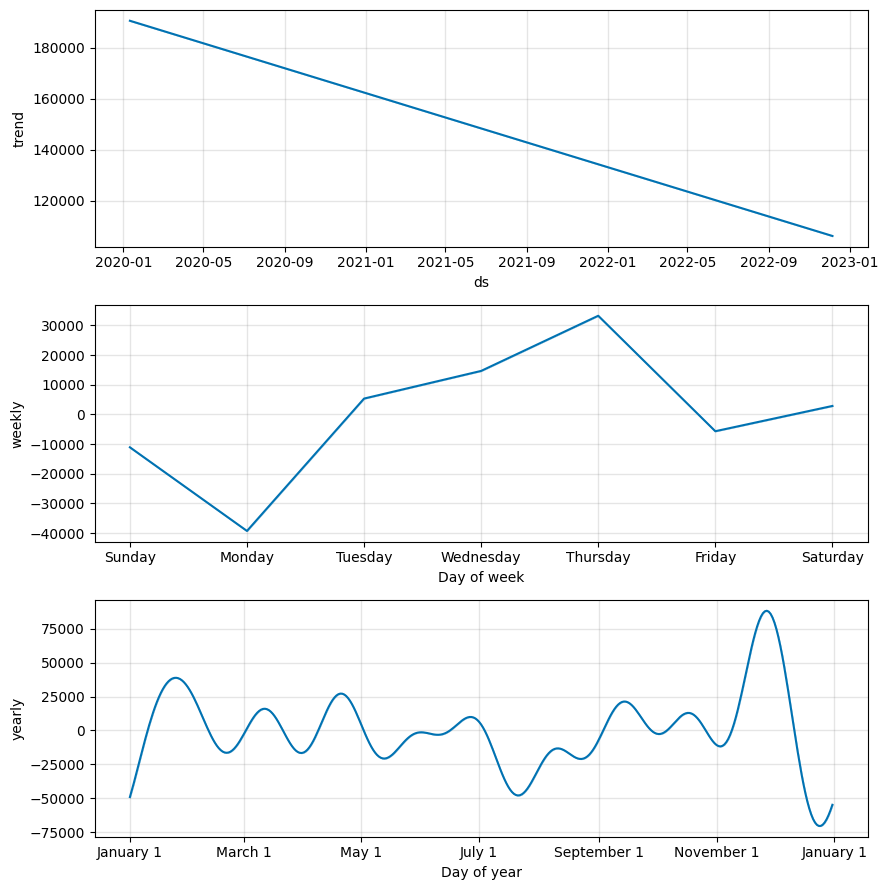

In [4]:
import pandas as pd

# I am not sure whether this data set is real, dummy, or simulated data, but for me, it looks more realistic than any other data I found on the internet.
df = pd.read_csv("https://raw.githubusercontent.com/haensel-ams/recruitment_challenge/master/DataScience_202209/MMM_test_data.csv",parse_dates=["start_of_week"])

# 1. media variables
# spend channels
mdsp_cols=['spend_channel_1', 'spend_channel_2',
       'spend_channel_3', 'spend_channel_4', 'spend_channel_5',
       'spend_channel_6', 'spend_channel_7']

# 2. control variables
# trend and Year
prophet_data = df.rename(columns = {'revenue': 'y', 'start_of_week': 'ds'})
prophet = Prophet(yearly_seasonality=True)
prophet.fit(prophet_data[["ds", "y"]])
prophet_predict = prophet.predict(prophet_data[["ds", "y"]])
prophet.plot_components(prophet_predict)

df["trend"] = prophet_predict["trend"]
df["season"] = prophet_predict["yearly"]

# holiday variables
hldy_cols = ['trend']
# seasonality variables
seas_cols = ['season']

control_vars =  hldy_cols + seas_cols

# 3. sales variables
sales_cols =['revenue']

df_main = df[['start_of_week']+sales_cols+mdsp_cols+control_vars]
# Simplified media channel for demo
#df_main = df_main.rename(columns={'spend_channel_1': 'Direct Mail', 'spend_channel_2': 'Insert', 'spend_channel_3': 'Newspaper', 'spend_channel_4': 'Radio', 'spend_channel_5': 'TV', 
#                                  'spend_channel_6': 'Social Media', 'spend_channel_7': 'Online Display'})
#mdsp_cols = ["Direct Mail","Insert", "Newspaper", "Radio", "TV", "Social Media", "Online Display"]

In [5]:
df_main.head()

,start_of_week,revenue,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7,trend,season
0,2020-08-30,157906.75,2625.48,262.71,12954.12,3609.63,12955.29,12659.12,19379.79,190660.370742,307.189326
1,2020-06-09,186425.68,2634.01,108.66,8760.28,4560.60,12747.70,12338.18,22473.45,183473.628709,5541.622060
2,2020-09-13,161607.39,2087.08,110.32,7155.42,4362.96,15015.41,10811.15,22596.05,178682.467353,-3181.344643
3,2020-09-20,180089.13,1690.70,52.79,15185.22,3883.41,15521.41,12890.22,24728.73,178442.909285,-2627.588883
4,2020-09-27,217793.98,1547.30,80.56,18524.05,4043.09,15793.74,12642.55,26515.48,173651.747998,-13250.441651


In [6]:
df_main.describe()

,revenue,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7,trend,season
count,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000
mean,136490.190673,1245.604808,343.640962,19507.177981,6915.136731,8575.611442,5063.699038,27701.367404,143386.035096,225.026495
std,50810.253012,1388.384632,332.988218,8714.759886,3123.172035,6956.787524,6689.472660,12176.293684,18699.169974,27434.251887
min,63207.090000,0.000000,4.370000,5938.130000,3602.200000,747.460000,0.000000,9391.210000,106067.039409,-69541.202765
25%,101675.685000,334.275000,120.470000,13879.000000,5113.937500,2902.032500,0.000000,19797.710000,128459.046608,-13495.886139
50%,128790.460000,856.870000,202.020000,17929.450000,6194.400000,6879.270000,2423.095000,24248.640000,143354.006243,-2206.862659
75%,157707.280000,1658.032500,553.075000,22252.262500,7470.557500,14367.582500,8701.960000,33852.652500,157541.501702,13464.042224
max,418186.380000,8513.830000,1605.850000,49689.380000,22629.690000,33009.650000,33692.830000,77488.420000,190660.370742,87690.619638


In [7]:
seed=405

data_size = len(df_main)

n_media_channels = len(mdsp_cols)
n_extra_features = len(control_vars)
media_data = df_main[mdsp_cols].to_numpy()
extra_features = df_main[control_vars].to_numpy()
target = df_main['revenue'].to_numpy()
costs = df_main[mdsp_cols].sum().to_numpy()

Splitting the data into train and test. Keeping last 24 weeks for testing

In [8]:
# Split and scale data.
test_data_period_size = 24
split_point = data_size - test_data_period_size
# Media data
media_data_train = media_data[:split_point, ...]
media_data_test = media_data[split_point:, ...]
# Extra features
extra_features_train = extra_features[:split_point, ...]
extra_features_test = extra_features[split_point:, ...]
# Target
target_train = target[:split_point]

Scaling the data

In [9]:
media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
extra_features_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean, multiply_by=0.15)

media_data_train = media_scaler.fit_transform(media_data_train)
extra_features_train = extra_features_scaler.fit_transform(extra_features_train)
target_train = target_scaler.fit_transform(target_train)
costs = cost_scaler.fit_transform(costs)

# Training the model


In [10]:
mmm = lightweight_mmm.LightweightMMM(model_name="hill_adstock")

Training the model will require the following mandatory parameters:

- media
- total_costs (one value per channel)
- target

We can optionally also pass the following:

* extra_features: Other variables to add to the model.
* degrees_seasonality: Number of degrees to use for seasonality. Default is 3.
* seasonality_frequency: Frequency of the time period used. Default is 52 as in 52 weeks per year.
* media_names: Names of the media channels passed.
* number_warmup: Number of warm up samples. Default is 1000.
* number_samples: Number of samples during sampling. Default is 1000.
* number_chains: Number of chains to sample. Default is 2.




In [11]:
number_warmup=1000
number_samples=1000

In [12]:
# For replicability in terms of random number generation in sampling
# reuse the same seed for different trainings.
mmm.fit(
    media=media_data_train,
    media_prior=costs,
    target=target_train,
    extra_features=extra_features_train,
    number_warmup=number_warmup,
    number_samples=number_samples,
    media_names = mdsp_cols,
    seed=seed)

/usr/local/lib/python3.9/dist-packages/lightweight_mmm/lightweight_mmm.py:357: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(
sample: 100%|██████████| 2000/2000 [00:26<00:00, 76.40it/s, 127 steps of size 2.52e-02. acc. prob=0.89]


Summary of the trace

In [13]:
mmm.print_summary()


                                         mean       std    median      5.0%     95.0%     n_eff     r_hat
             coef_extra_features[0]     -0.24      0.58     -0.19     -1.15      0.68    452.36      1.00
             coef_extra_features[1]      0.01      0.00      0.01      0.01      0.01   2294.61      1.00
                      coef_media[0]      0.02      0.01      0.01      0.00      0.03   2203.52      1.00
                      coef_media[1]      0.00      0.00      0.00      0.00      0.01   2358.69      1.00
                      coef_media[2]      0.35      0.22      0.33      0.00      0.65    635.01      1.00
                      coef_media[3]      0.08      0.06      0.07      0.00      0.17   2512.85      1.00
                      coef_media[4]      0.10      0.08      0.08      0.00      0.21   1545.13      1.00
                      coef_media[5]      0.07      0.05      0.06      0.00      0.14   1985.40      1.00
                      coef_media[6]      0.40

We can visualise the posterior distributions of the media effects:

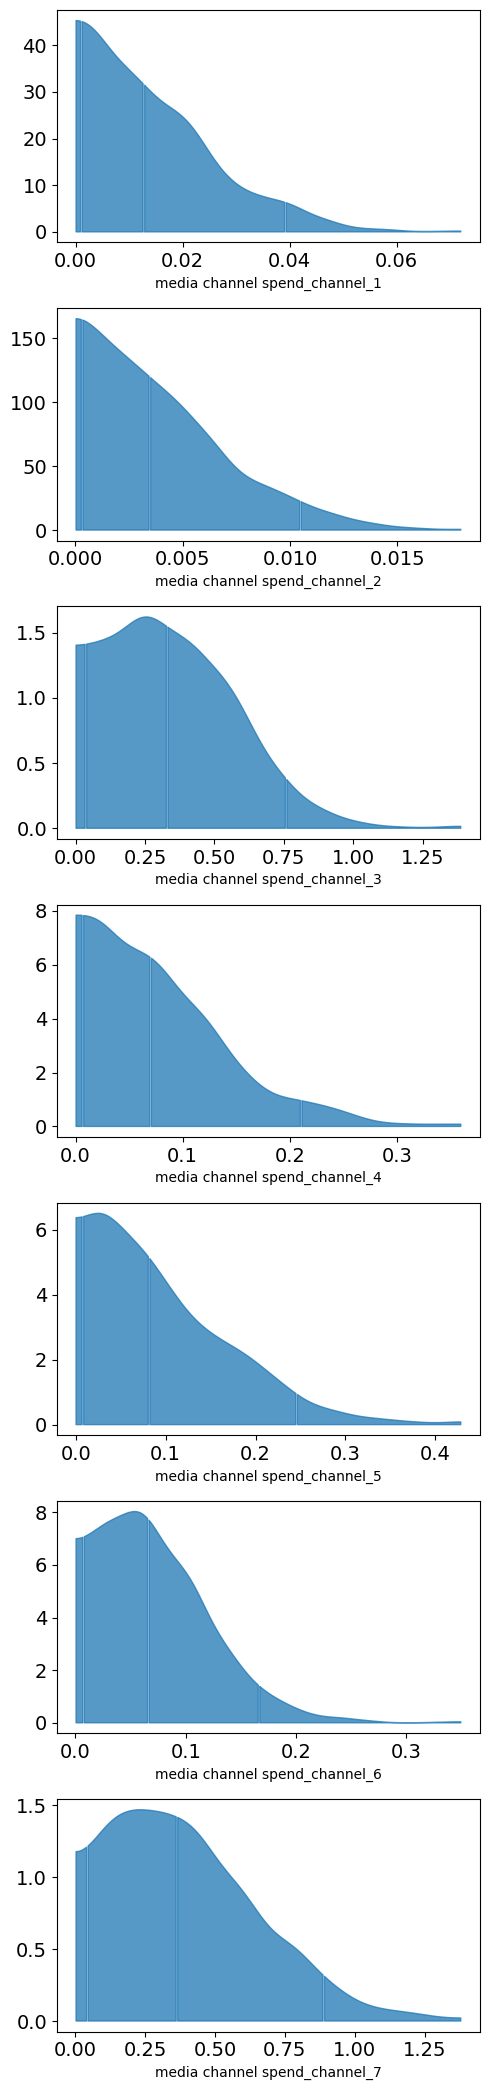

In [14]:
import warnings
warnings.filterwarnings('ignore')
plot.plot_media_channel_posteriors(media_mix_model=mmm, channel_names=mdsp_cols)

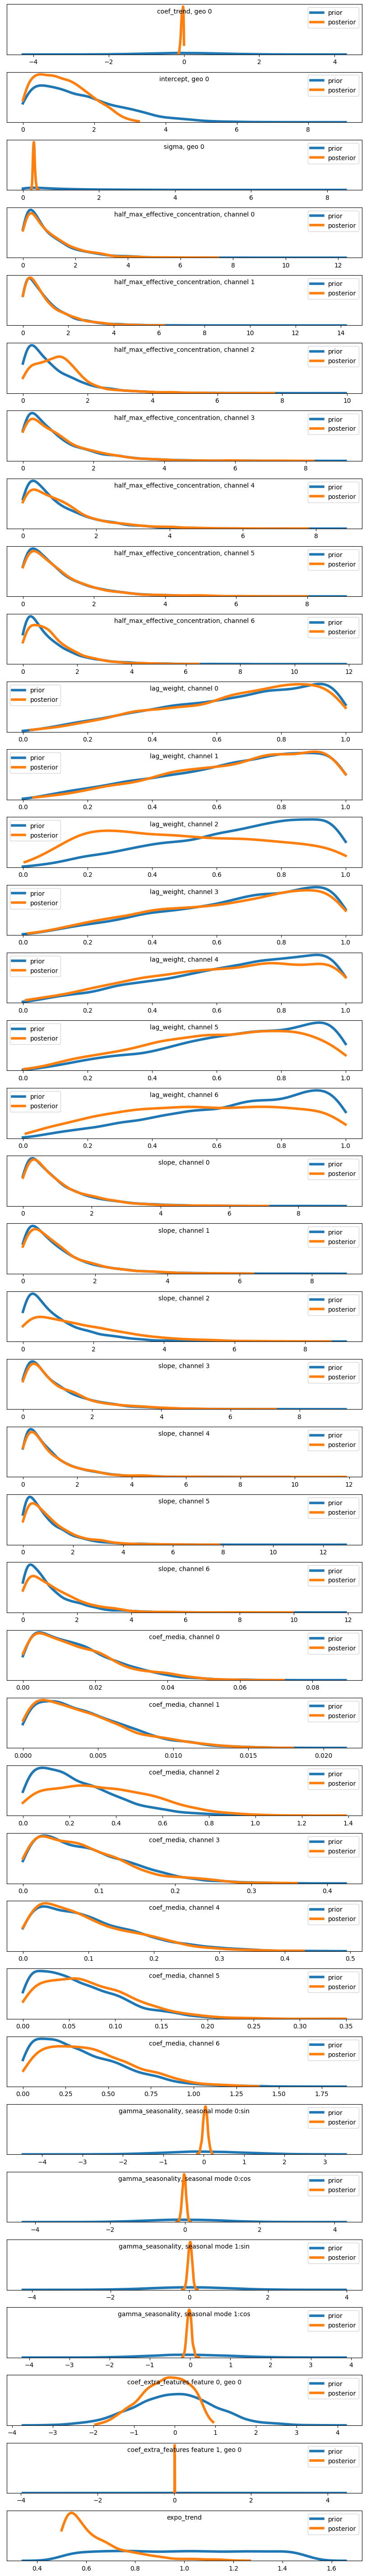

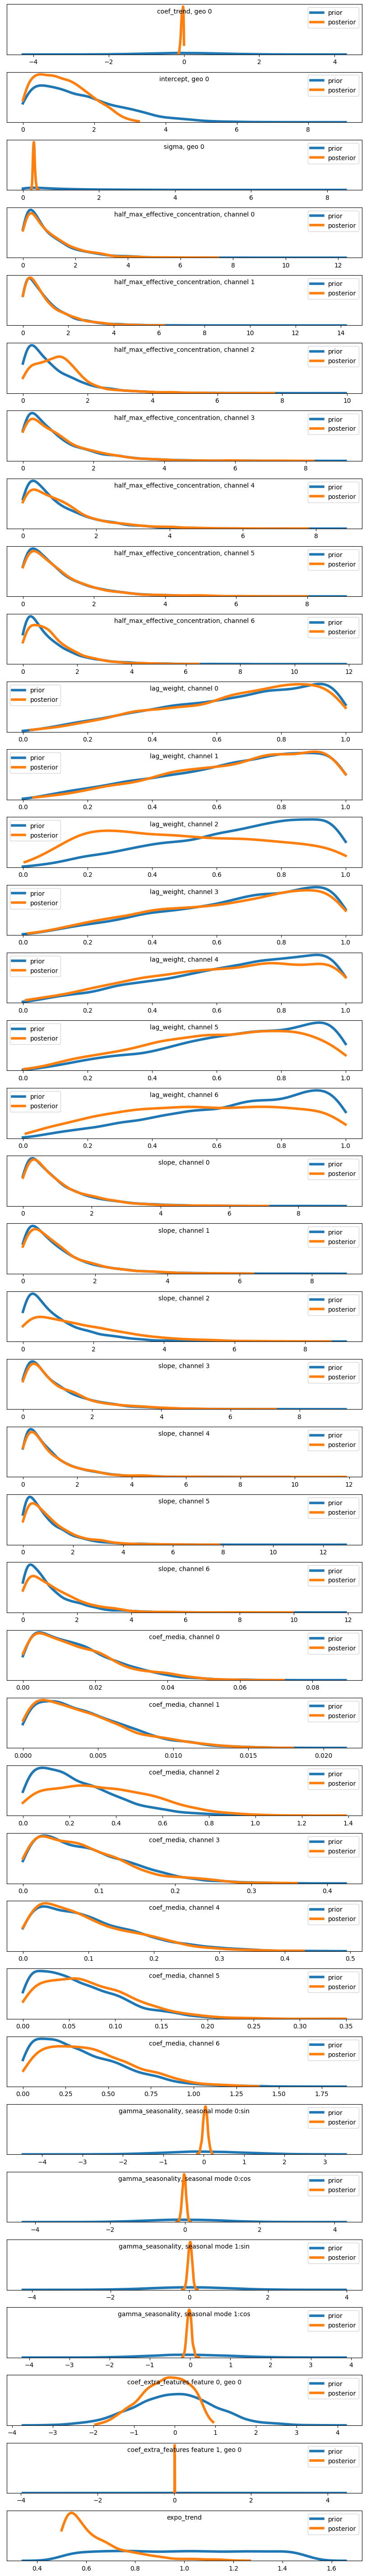

In [15]:
plot.plot_prior_and_posterior(media_mix_model=mmm)

model's fit to the training data.

In [21]:
import warnings
warnings.filterwarnings('ignore')

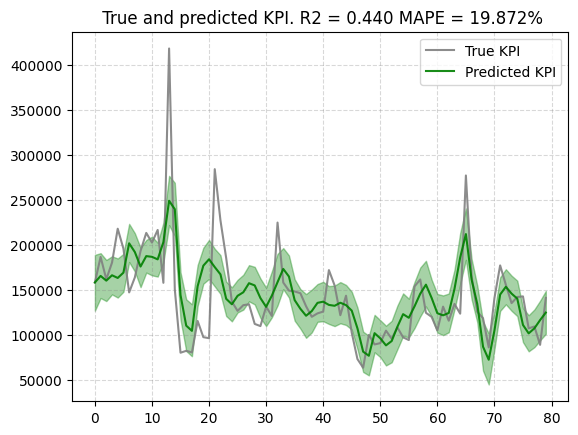

In [16]:
# Here is another example where we can pass the target scaler if you want the plot to be in the "not scaled scale"
plot.plot_model_fit(mmm, target_scaler=target_scaler)

Predictions on unseen data 

In [17]:
# We have to scale the test media data if we have not done so before.
new_predictions = mmm.predict(media=media_scaler.transform(media_data_test),
                              extra_features=extra_features_scaler.transform(extra_features_test),
                              seed=seed)

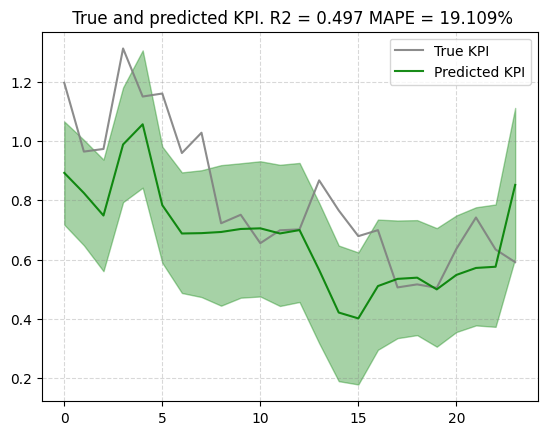

In [18]:
plot.plot_out_of_sample_model_fit(out_of_sample_predictions=new_predictions,
                                 out_of_sample_target=target_scaler.transform(target[split_point:]))

**Media Insights**

In [19]:
media_contribution, roi_hat = mmm.get_posterior_metrics(target_scaler=target_scaler, cost_scaler=cost_scaler)

Visualise the estimated media & baseline contribution over time

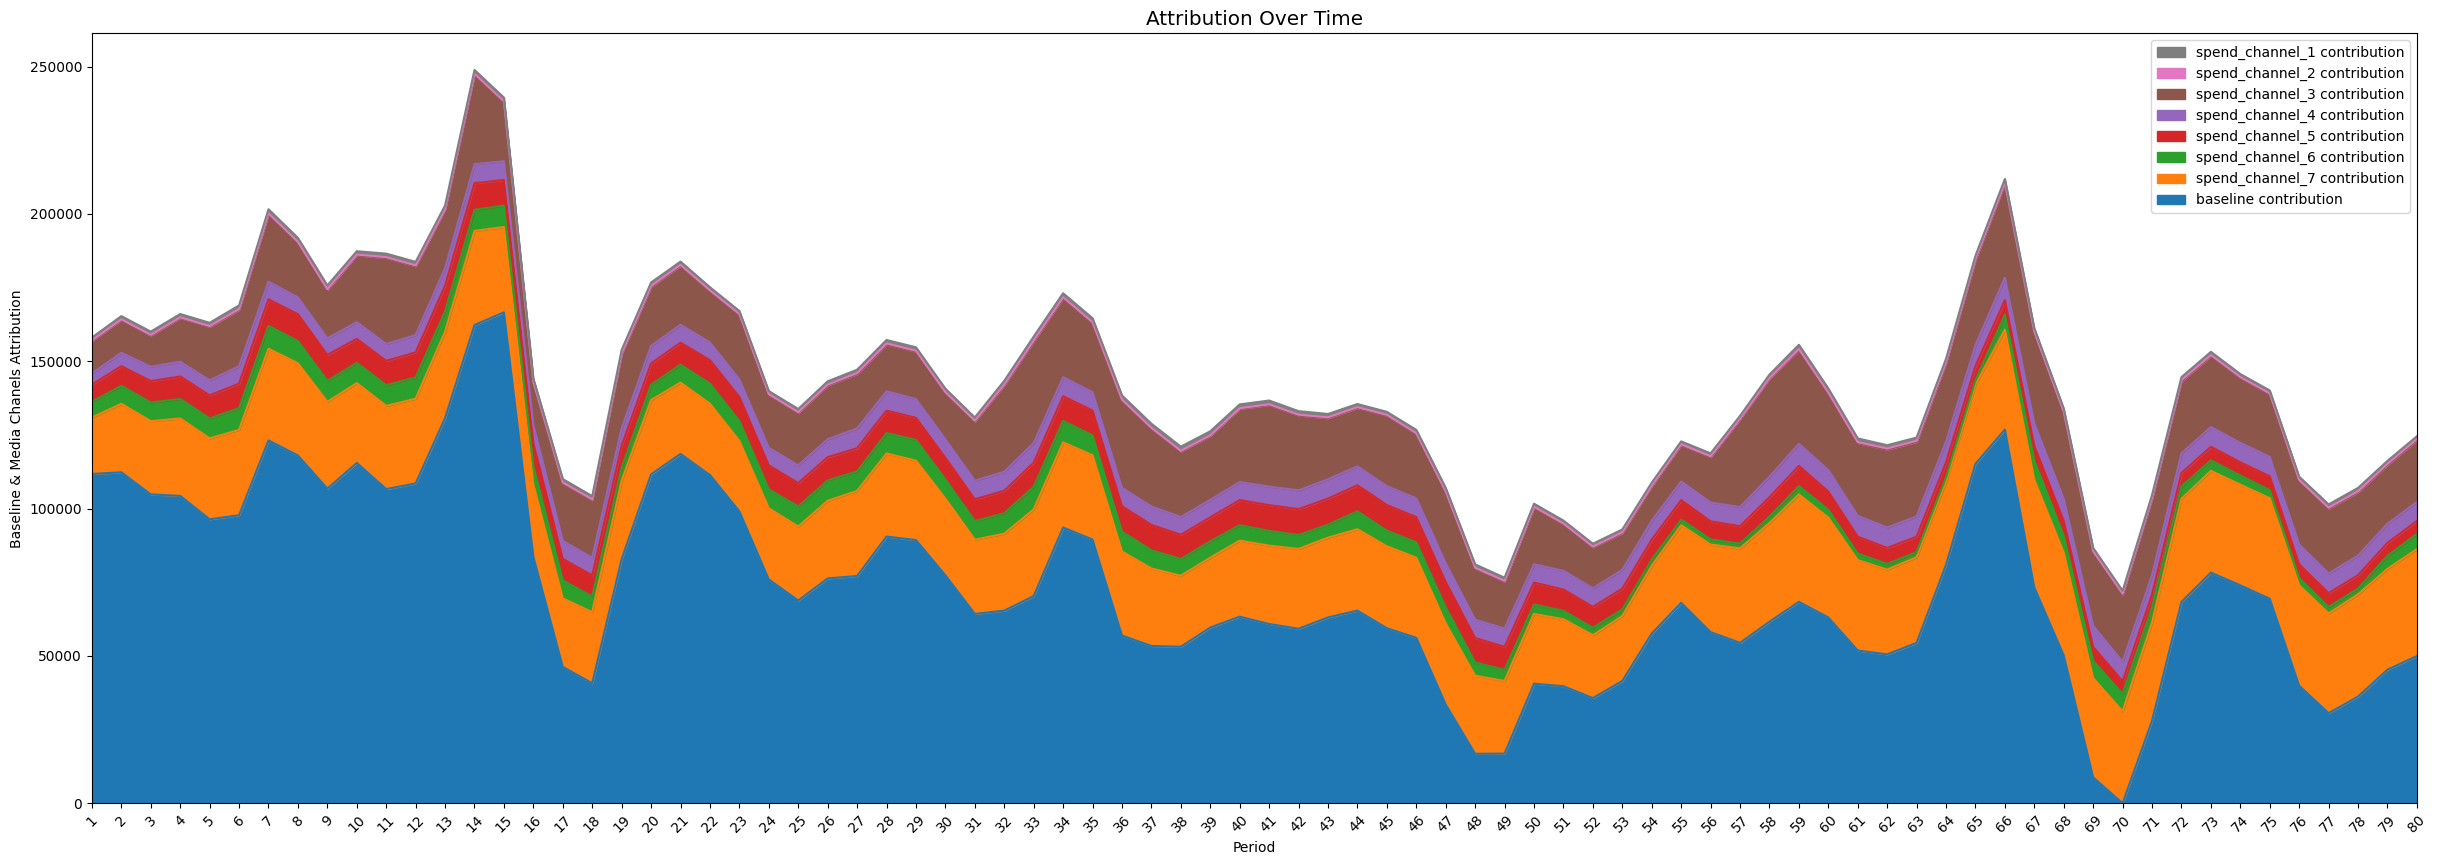

In [20]:
plot.plot_media_baseline_contribution_area_plot(media_mix_model=mmm,
                                                target_scaler=target_scaler,
                                                fig_size=(30,10),
                                                channel_names = mdsp_cols
                                                )

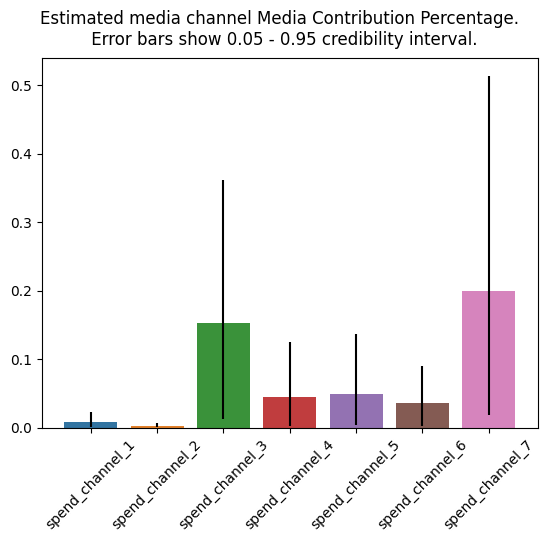

In [21]:
plot.plot_bars_media_metrics(metric=media_contribution, metric_name="Media Contribution Percentage", channel_names=mdsp_cols)

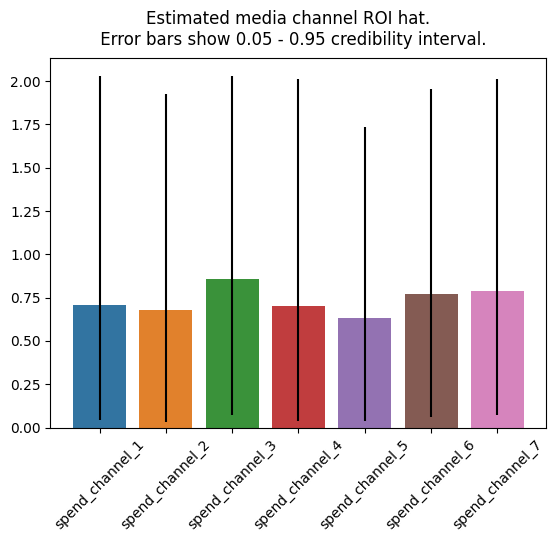

In [22]:
plot.plot_bars_media_metrics(metric=roi_hat, metric_name="ROI hat", channel_names=mdsp_cols)

 Let's find out how each media channel behaves individually as we invest more in it.

For that we can plot the curve response of all media channels with the following function:

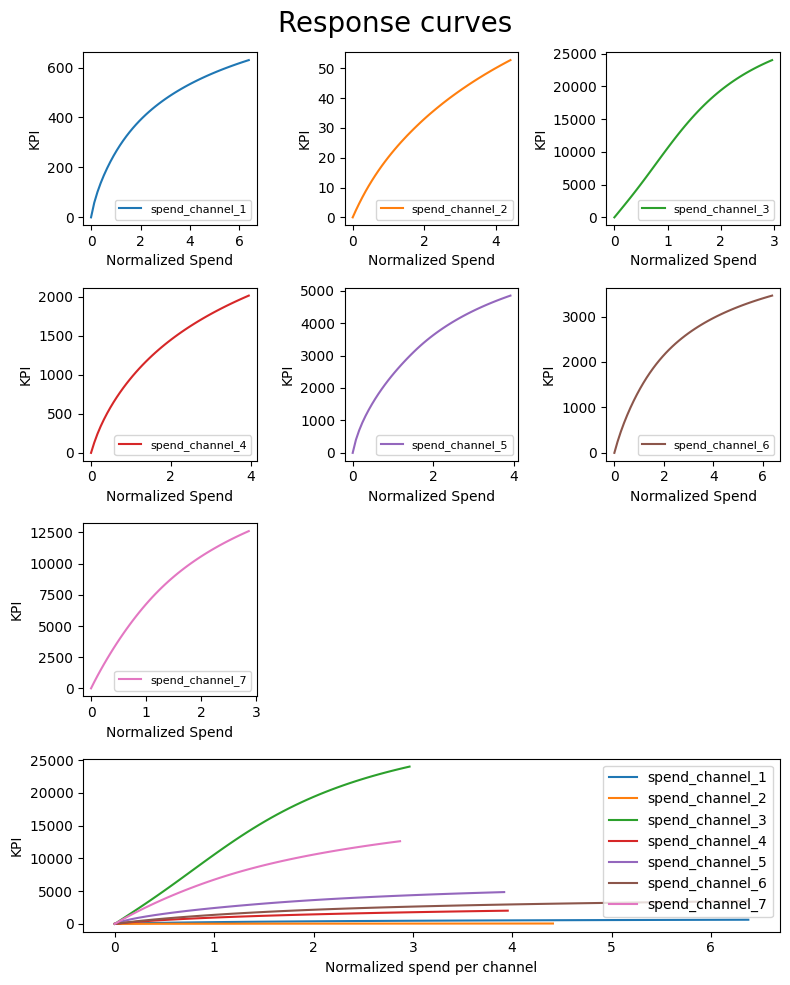

In [23]:
plot.plot_response_curves(media_mix_model=mmm, target_scaler=target_scaler, seed=seed)

**Optimization**

We will want to optimize the allocation of resources to the different spend channels. 

In [24]:
prices = jnp.ones(mmm.n_media_channels)

In [25]:
n_time_periods = 20  # budget is how much one would like to allocate throughtout the total of n_time_periods
budget = jnp.sum(jnp.dot(prices, media_data.mean(axis=0)))* n_time_periods

In [26]:
# Run optimization with the parameters of choice.
solution, kpi_without_optim, previous_media_allocation = optimize_media.find_optimal_budgets(
    n_time_periods=n_time_periods,
    media_mix_model=mmm,
    extra_features=extra_features_scaler.transform(extra_features_test)[:n_time_periods],
    budget=budget,
    prices=prices,
    media_scaler=media_scaler,
    target_scaler=target_scaler,
    seed=seed)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -2033269.9172152977
            Iterations: 47
            Function evaluations: 690
            Gradient evaluations: 46


In [27]:
# Obtain the optimal weekly allocation.
optimal_buget_allocation = prices * solution.x
optimal_buget_allocation

Array([ 25633.193,   3622.782, 472250.97 , 109853.11 , 161703.4  ,
       101505.45 , 512475.84 ], dtype=float32)

In [28]:
# similar renormalization to get previous budget allocation
previous_budget_allocation = prices * previous_media_allocation
previous_budget_allocation

Array([ 31418.809,   4440.472, 385894.5  , 134647.81 , 198201.14 ,
       124416.01 , 508026.03 ], dtype=float32)

In [29]:
# Both these values should be very close in order to compare KPI
budget, optimal_buget_allocation.sum()

(Array(1387044.8, dtype=float32), Array(1387044.8, dtype=float32))

In [30]:
# Both numbers should be almost equal
budget, jnp.sum(solution.x * prices)

(Array(1387044.8, dtype=float32), Array(1387044.8, dtype=float32))

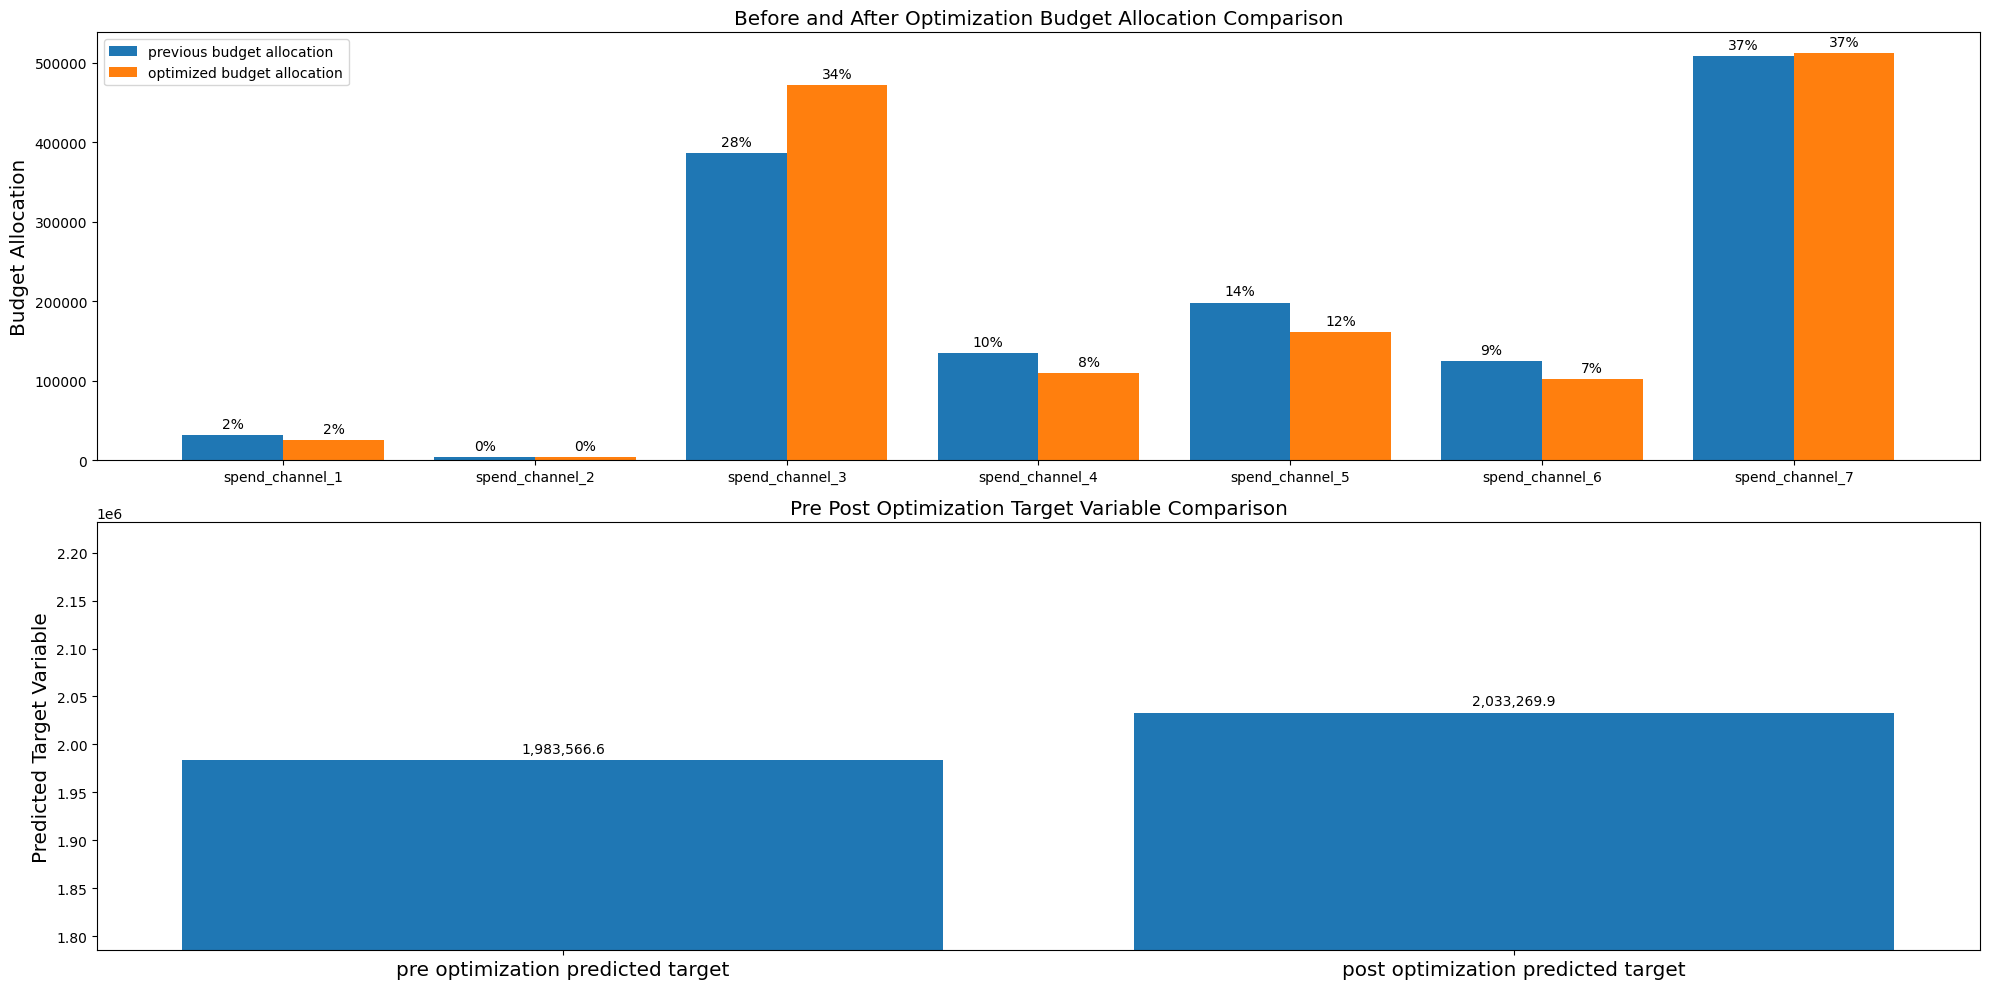

In [34]:
# Plot out pre post optimization budget allocation and predicted target variable comparison.
plot.plot_pre_post_budget_allocation_comparison(media_mix_model=mmm, 
                                                kpi_with_optim=solution['fun'], 
                                                kpi_without_optim=kpi_without_optim,
                                                optimal_buget_allocation=optimal_buget_allocation, 
                                                previous_budget_allocation=previous_budget_allocation, 
                                                figure_size=(20,10),
                                                channel_names = mdsp_cols)

Saving the model

In [ ]:
# We can use the utilities for saving models to disk.
file_path = "media_mix_model.pkl"
utils.save_model(media_mix_model=mmm, file_path=file_path)

In [ ]:
# Once saved one can load the models.
loaded_mmm = utils.load_model(file_path=file_path)
loaded_mmm.trace["coef_media"].shape # Example of accessing any of the model values.